### Confounded cuisiner data challenge

The aim here is to classify a group of recipies accoriding to cuisine. This is an unsupervised learning problem because the recipies are not labelled. Thus we are going to use clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string 
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

plt.style.use('ggplot')
%matplotlib inline

Read the recipies from json

In [2]:
recipies = pd.read_json('unlabelled_recipies.json')

Some useful functions

In [3]:
exclude = string.punctuation.replace(',','')

def convert_to_list(element):
    
    '''Convert the recipies into a list, if they are not currently in that format'''
    
    if type(element) != list:
        element = element.strip("][").split(',')
    
    return element

def clean_string(element):
    
    '''Convert recipie list into a string. Convert to lower case and then remove punctuation'''
    
    element = ', '.join(element)
    element = element.strip().lower()
    element = ''.join(ch for ch in element if ch not in exclude)
    
    return element
    

Apply these functions

In [4]:
recipies['ingredients'] = recipies['ingredients'].apply(convert_to_list)
recipies['ingredients_clean_string'] = recipies['ingredients'].apply(clean_string)

In [5]:
recipies.head(10)

,ingredients,ingredients_clean_string
0,"[pepper, bacon, russet potatoes, sugar, onions...","pepper, bacon, russet potatoes, sugar, onions,..."
1,"['rib', 'carrots', 'leeks', 'unsalted butte...","rib, carrots, leeks, unsalted butter, fine..."
10,"[orzo, garlic, heavy cream, white wine, spinac...","orzo, garlic, heavy cream, white wine, spinach..."
100,"['garlic', 'ginger', 'fish sauce', 'chayote...","garlic, ginger, fish sauce, chayotes, cook..."
1000,"[onions, avocado, salt, coconut cream, cumin s...","onions, avocado, salt, coconut cream, cumin se..."
10000,"[salt, onion salt, paprika, ground cumin, dice...","salt, onion salt, paprika, ground cumin, diced..."
10001,"[fennel seeds, sugar cane juice, ice, thai bas...","fennel seeds, sugar cane juice, ice, thai basi..."
10002,"[hot water, part-skim ricotta cheese, provolon...","hot water, partskim ricotta cheese, provolone ..."
10003,"[lemon juice, salt, egg whites, milk, egg yolk...","lemon juice, salt, egg whites, milk, egg yolks..."
10004,"['sambal ulek', 'brown sugar', 'peeled fresh...","sambal ulek, brown sugar, peeled fresh ginge..."


Find all unique ingredients and put them in a dictionary   
We need to make sure that common redundant words are not repeated

In [6]:
unique_ingredients = {}

reserved_words = ['black pepper','flour','onion','lemon juice','lime juice','eggs',
                  'olive oil','butter','milk','water','egg yolk','egg white','sugar','salt',
                  'lemon','bell pepper','cocoa','vanilla','tomatoes','potato']
pepper_phrases = ['pepper','freshly ground pepper','ground pepper']


for index, row in recipies.iterrows():
    
    ingredients_list = row['ingredients_clean_string'].split(',')
    for element in ingredients_list:
        element = element.strip()
        
        for word in reserved_words:
            if word in element:
                element = word
                
        if element in pepper_phrases:
            element = 'black pepper'
                
        if element not in unique_ingredients:
            unique_ingredients[element] = 1
        else:
            unique_ingredients[element] += 1

In [7]:
len(unique_ingredients)

5997

In [8]:
sorted_keys = list(sorted(unique_ingredients, key=unique_ingredients.__getitem__)[::-1])
sorted_values = list(sorted(unique_ingredients.values()))[::-1]

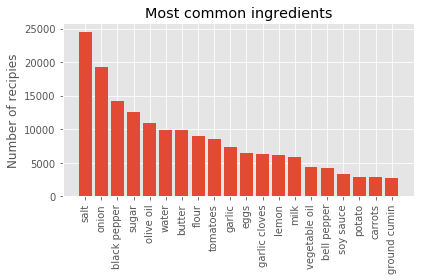

In [9]:
plt.figure(figsize=(6,4))
x = np.arange(20)
plt.bar(x=x,height=sorted_values[:20])
plt.xticks(x, sorted_keys[:20], rotation='vertical')
plt.title('Most common ingredients')
plt.ylabel('Number of recipies')
plt.tight_layout()
plt.savefig('top20_ingredients2.png',dpi=200)
plt.show()

Some ingredients are redundant - an easy potential fix here is just to preserve those that appear more than 5 times in the corpus

In [10]:
main_unique_ingredients = dict((name, number) for name, number in unique_ingredients.items() if number >= 10) 

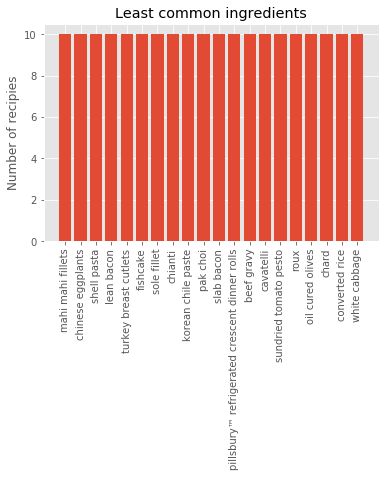

In [11]:
sorted_keys = list(sorted(main_unique_ingredients, key=unique_ingredients.__getitem__)[::-1])
sorted_values = list(sorted(main_unique_ingredients.values()))[::-1]

x = np.arange(20)
plt.bar(x=x,height=sorted_values[-20:])
plt.xticks(x, sorted_keys[-20:], rotation='vertical')
plt.title('Least common ingredients')
plt.savefig('bottom20_ingredients2.png',dpi=200)
plt.ylabel('Number of recipies')
plt.show()

Now make a matrix containing that number of rows by the number of cols in the dataset

In [12]:
ingredient_names = list(main_unique_ingredients.keys())

In [13]:
Z = np.zeros([len(recipies),len(main_unique_ingredients)])

for index, row in recipies.iterrows():
    ingredients_list = row['ingredients_clean_string'].split(',')
    for element in ingredients_list:
        element = element.strip()
        
        for word in reserved_words:
            if word in element:
                element = word
                
        if element in pepper_phrases:
            element = 'black pepper'
            
        if element in ingredient_names:
            eleind = ingredient_names.index(element)
            Z[index,eleind] = 1
            

In [14]:
n_ingredients, n_recipies = np.shape(Z)

#### Tf-idf on each word
This is done so that we can take the abundance of each word into account. High values will tend to be 'important' words that are relatively unique to this recipie

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


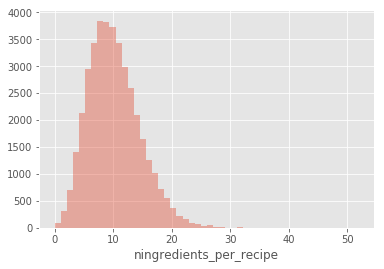

In [15]:
Z = pd.DataFrame(Z)
Z['ningredients_per_recipe'] = Z.sum(axis=1)
sns.distplot(Z['ningredients_per_recipe'],kde=False)
plt.savefig('Number_ingredients_per_recipe.png',dpi=200)

In [16]:
Z1 = Z.as_matrix().copy()
for i in range(len(ingredient_names)):
    Z1[:,i] = Z1[:,i]*np.log(n_recipies/np.sum(Z1[:,i]))

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [17]:
np.shape(Z1)

(39774, 2127)

In [18]:
Z1 = pd.DataFrame(Z1)
Z1.columns = ingredient_names+['ningredients']

In [19]:
Z1.head()

,black pepper,bacon,potato,sugar,onion,gochugaru,olive oil,shredded cheddar cheese,kimchi,scallions,...,raspberry preserves,cream of coconut,biscuit dough,stew meat,brioche,flavored oil,buckwheat noodles,frozen sweet corn,cornish game hens,ningredients
0,-1.872815,1.227451,-0.300766,-1.652523,-2.114736,4.2608,-1.616936,1.016907,2.943499,0.117136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
1,-0.000000,0.000000,-0.300766,-0.000000,-2.114736,0.0000,-0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2,-1.872815,0.000000,-0.000000,-0.000000,-0.000000,0.0000,-0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,-0.000000,0.000000,-0.000000,-1.652523,-0.000000,0.0000,-0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
4,-0.000000,0.000000,-0.000000,-1.652523,-0.000000,0.0000,-0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


#### We now have a matrix that contains ~40,000 recipies and 2126 possible ingredients 
The aim is now to run a clustering algorithm to group them into cuisines.  
Its not clear how many clusters we should use.   

Lets use Kmeans with a range of them and make an elbow plot to help us decide the number of clusters

In [20]:
n_clusters = [2,4,6,8,10,12,14,16,18,20]
distortions = []
s_scores = []

In [21]:
%%time
for clusters in n_clusters:
    cluster_algorithm = KMeans(n_clusters=clusters, n_jobs=4).fit(Z1)
    #The intertia measures the the extent to which the values are close to their nearest cluster
    #centroid
    distortions.append(cluster_algorithm.inertia_)
    silhouette_avg = silhouette_score(Z1, cluster_algorithm.labels_)
    s_scores.append(silhouette_avg)
    print('Done clustering with n_clusters = %i' %clusters)

Done clustering with n_clusters = 2
Done clustering with n_clusters = 4
Done clustering with n_clusters = 6
Done clustering with n_clusters = 8
Done clustering with n_clusters = 10
Done clustering with n_clusters = 12
Done clustering with n_clusters = 14
Done clustering with n_clusters = 16
Done clustering with n_clusters = 18
Done clustering with n_clusters = 20
CPU times: user 56min 20s, sys: 2min 10s, total: 58min 30s
Wall time: 33min 27s


In [22]:
distortions

[1838569.8231521598,
 1653668.0761671353,
 1606025.8513750995,
 1580354.4027724355,
 1558465.0352683973,
 1548957.6645678505,
 1537680.9915633444,
 1531656.3157406694,
 1520644.6402040818,
 1519284.571866627]

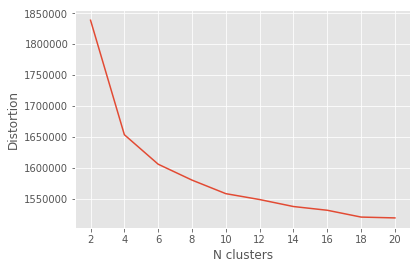

In [23]:
plt.plot(n_clusters,distortions)
plt.xlabel('N clusters')
plt.ylabel('Distortion')
plt.xticks(n_clusters, n_clusters)
plt.savefig("Elbow_plot.png",dpi=200)

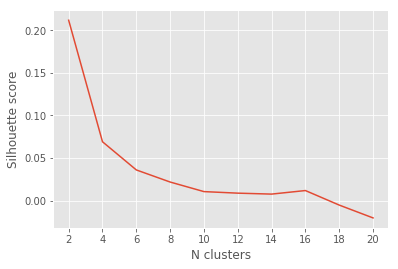

In [24]:
plt.plot(n_clusters,s_scores)
plt.xlabel('N clusters')
plt.ylabel('Silhouette score')
plt.xticks(n_clusters, n_clusters)
plt.savefig('Silhoutte_plot.png',dpi=200)

Lets choose 8 clusters, based on the result of the elbow plot anf silhouette plot

In [25]:
cluster_algorithm = KMeans(n_clusters=15, n_jobs=4).fit(Z1)

In [26]:
Z1['label'] = list(cluster_algorithm.labels_)

In [27]:
def make_cluster_tf_idf_plot(series,plot_name):
    
    fig = plt.figure(figsize=(4,5))
    ax = fig.add_subplot(111)
    
    labels = list(series.keys()[1:])
    values = series.values[1:]
    ax.barh(y=labels,width=values,alpha=0.5)
    plt.tight_layout()
    plt.savefig(plot_name,dpi=200)

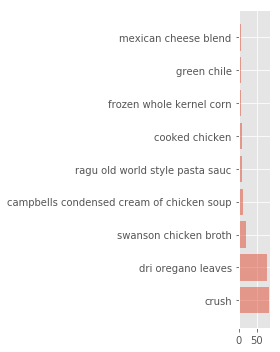

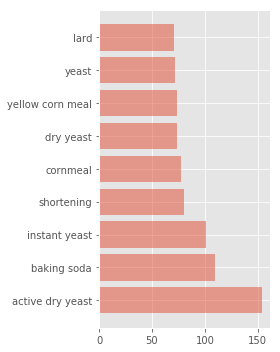

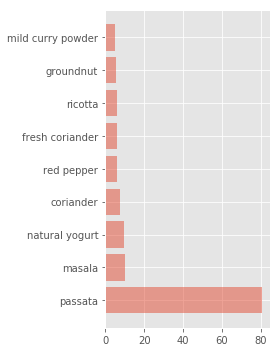

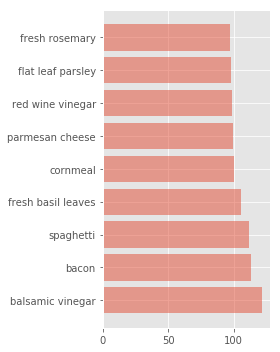

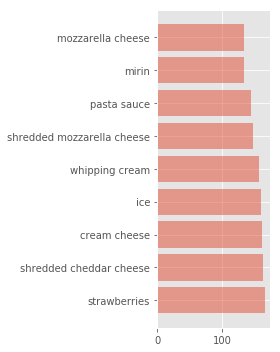

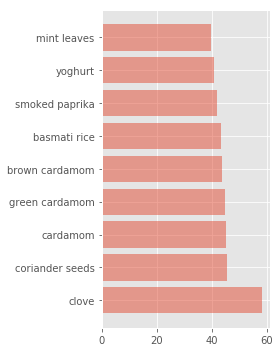

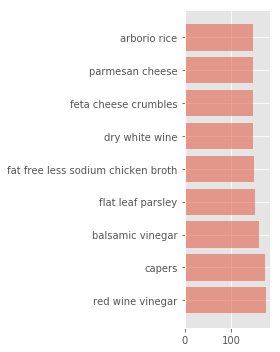

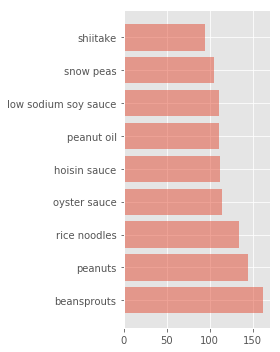

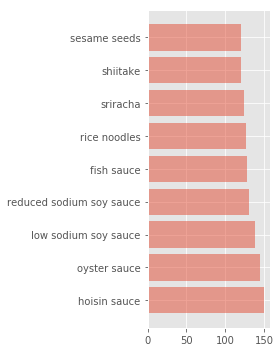

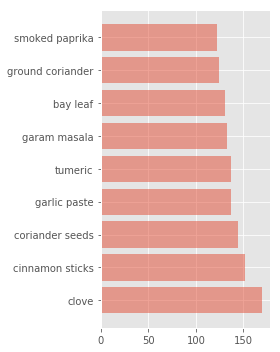

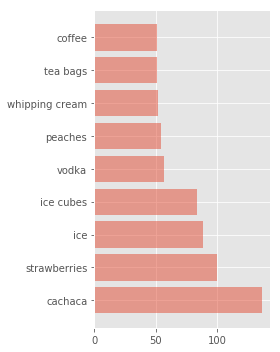

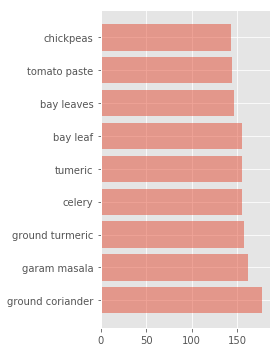

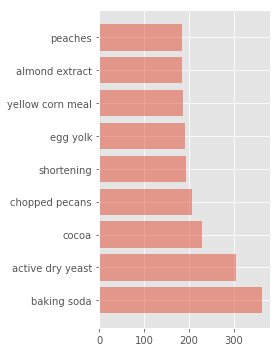

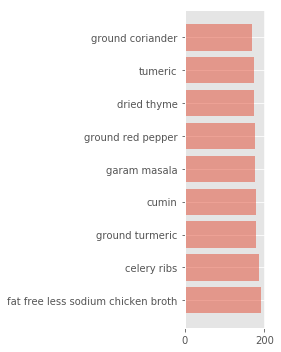

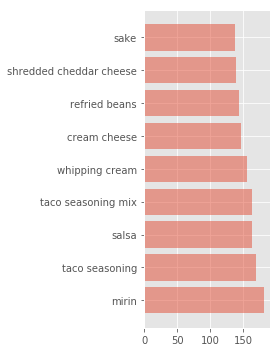

In [28]:
for i in range(15):
    plot_name = 'Ingredients_cuisine_%i.png' %i
    top_ingredients = Z1[Z1['label']==i].drop('label',axis=1).sum().sort_values(ascending=False).iloc[:10]
    make_cluster_tf_idf_plot(top_ingredients,plot_name)

In [51]:
def plot_2d_space(X, label='Dataset PCA'): 
    
    '''Do a PCA and plot 2D space showing the classes'''
    
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    
    plt.scatter(X[:, 0],X[:, 1])
    plt.title(label)
    plt.savefig("PCA_test.png",dpi=200)
    plt.show()

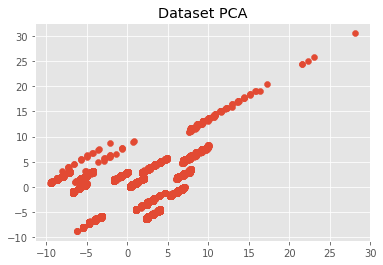

In [52]:
plot_2d_space(Z1)


In [36]:
examples_per_cluster = Z1[['ningredients','label']].groupby('label').count()

In [45]:
xlabs = list(examples_per_cluster.index)
yvals = examples_per_cluster['ningredients'].values

In [46]:
xlabs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

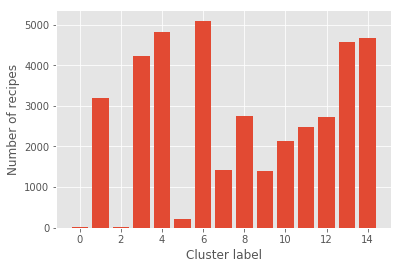

In [50]:
plt.bar(xlabs,height=yvals)
plt.xlabel("Cluster label")
plt.ylabel("Number of recipes")
plt.savefig('Recipies_per_cluster.png',dpi=200)